In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [7]:
anno_df = pd.read_csv(
    DATA_DIR / "celeba" / "CelebAMask-HQ" / "CelebAMask-HQ-attribute-anno.txt",
    header=1,
    delimiter=" ",
)
anno_df["id"] = [int(i[0].split(".")[0]) for i in anno_df.index.values]

In [8]:
hair_types = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bald']
# make a category for hair color
anno_df['hair_category'] = None
"""
for idx, row in tqdm(anno_df.iterrows(), total = len(anno_df)):
    hair_idx = np.where(row[hair_types] == 1)[0]
    if len(hair_idx) == 1:
        anno_df.loc[idx, 'hair_category']= hair_idx[0]
    elif len(hair_idx) > 1: 
        anno_df.loc[idx, 'hair_category']= -1
    else:
        anno_df.loc[idx, 'hair_category']= -2
"""

"\nfor idx, row in tqdm(anno_df.iterrows(), total = len(anno_df)):\n    hair_idx = np.where(row[hair_types] == 1)[0]\n    if len(hair_idx) == 1:\n        anno_df.loc[idx, 'hair_category']= hair_idx[0]\n    elif len(hair_idx) > 1: \n        anno_df.loc[idx, 'hair_category']= -1\n    else:\n        anno_df.loc[idx, 'hair_category']= -2\n"

In [9]:
print(list(anno_df.columns))

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'id', 'hair_category']


In [10]:
faces_128_df = pd.read_pickle(DATA_DIR / 'faces_128_full.pickle')

In [11]:
faces_128_df[:3]

,face,id
0,"[[[12, 12, 12], [12, 12, 12], [12, 12, 12], [1...",20142
1,"[[[12, 12, 12], [12, 12, 12], [12, 12, 12], [1...",8126
2,"[[[12, 12, 12], [12, 12, 12], [12, 12, 12], [1...",12655


In [12]:
from skimage.transform import resize

In [13]:
#imgs_64 = [resize(i, (64, 64)) for i in tqdm(faces_128_df.face.values)]
#faces_128_df['face'] = imgs_64

In [14]:
#imgs_64 = [resize(i, (64, 64)) for i in tqdm(faces_128_df.face.values)]
#faces_128_df['face'] = imgs_64
faces_128_df['face'] = faces_128_df.face.values / 256.

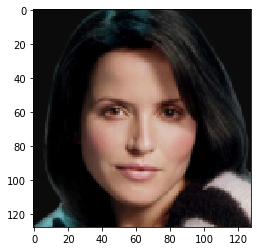

In [15]:
plt.imshow(faces_128_df['face'].values[0])

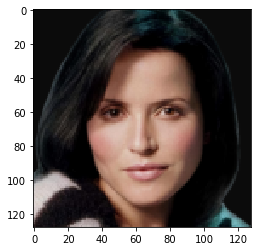

In [16]:
plt.imshow(np.fliplr(faces_128_df['face'].values[0]))

In [17]:
faces_128_df = pd.merge(faces_128_df, anno_df[['id', 'hair_category']], on=['id'])

In [18]:
len(faces_128_df)

30000

In [19]:
import copy

In [20]:
flipped_faces = [np.fliplr(i) for i in tqdm(faces_128_df.face.values)]

In [21]:
faces_128_df_flipped = copy.deepcopy(faces_128_df)

In [22]:
faces_128_df_flipped['faces'] = flipped_faces

In [23]:
faces_128_df = pd.concat([faces_128_df, faces_128_df_flipped]).reset_index()

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [24]:
faces_128_df['subset'] = 'train'
faces_128_df.loc[0:1000, 'subset'] = 'valid'
faces_128_df.loc[1000:1999, 'subset'] = 'test'

In [25]:
faces_128_df[:3]

,index,face,faces,hair_category,id,subset
0,0,"[[[0.046875, 0.046875, 0.046875], [0.046875, 0...",NaN,None,20142,valid
1,1,"[[[0.046875, 0.046875, 0.046875], [0.046875, 0...",NaN,None,8126,valid
2,2,"[[[0.046875, 0.046875, 0.046875], [0.046875, 0...",NaN,None,12655,valid


In [26]:
faces_128_df[-1:]

,index,face,faces,hair_category,id,subset
59999,29999,"[[[0.046875, 0.046875, 0.046875], [0.046875, 0...","[[[0.046875, 0.046875, 0.046875], [0.046875, 0...",None,17714,train


In [27]:
{hair_types[int(i)]:np.sum(faces_128_df['hair_category'] == i) for i in faces_128_df.hair_category.unique() if i in [0, 1,2,3,4]}

{}

In [28]:
Y_train = np.array(list(faces_128_df.hair_category.values[faces_128_df.subset == 'train'])).astype('float32')
Y_valid = np.array(list(faces_128_df.hair_category.values[faces_128_df.subset == 'valid'])).astype('float32')
Y_test = np.array(list(faces_128_df.hair_category.values[faces_128_df.subset == 'test'])).astype('float32')

In [29]:
X_train = np.array(list(faces_128_df.face.values[faces_128_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(faces_128_df.face.values[faces_128_df.subset == 'valid']))# / 255.
X_test = np.array(list(faces_128_df.face.values[faces_128_df.subset == 'test'])) #/ 255.

In [30]:
np.array(list(faces_128_df.face.values[faces_128_df.subset == 'train'])).shape

(58000, 128, 128, 3)

In [31]:
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

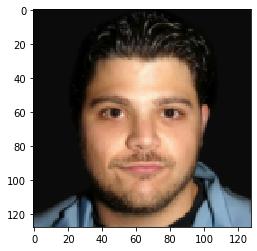

In [32]:
plt.imshow(X_train[0])

In [33]:
X_train_flat.shape, X_valid.shape, X_test.shape

((58000, 49152), (1000, 128, 128, 3), (1000, 128, 128, 3))

### define networks

In [34]:
dims = IMAGE_SHAPE = (128,128,3) 

### Keras network

In [35]:
#https://github.com/shaoanlu/MUNIT-keras/blob/master/MUNIT_keras.ipynb

In [36]:
# Architecture configs
IMAGE_SHAPE = (128,128,3)  # (128, 128, 3)
nc_in = 3 # number of input channels of generators
nc_D_inp = 3 # number of input channels of discriminators
n_dim_style = 8
n_resblocks = 4 # number of residual blocks in decoder and content encoder
n_adain = 2*n_resblocks
n_dim_adain = 256
nc_base = 64 # Number of channels of the first conv2d of encoder
n_downscale_content = 4 # Number of content encoder dowscaling
n_dowscale_style = 4 # Number of style encoder dowscaling
use_groupnorm = False # else use_layer norm in upscaling blocks
w_l2 = 1e-4 # L2 weight regularization
conv_init = 'he_normal'

In [37]:
from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.initializers import RandomNormal
#from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras import regularizers

In [38]:
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization

In [39]:
from tensorflow.keras.layers import (
    Lambda,
    Conv2D,
    GlobalAveragePooling2D,
    Dense,
    Reshape,
    Add,
    UpSampling2D,
    Flatten,
)

In [40]:
def ReflectPadding2D(x, pad=1):
    x = Lambda(
        lambda x: tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]], mode="REFLECT")
    )(x)
    return x


def conv_block(input_tensor, f, k=3, strides=2, use_norm=False):
    x = input_tensor
    x = ReflectPadding2D(x)
    x = Conv2D(
        f,
        kernel_size=k,
        strides=strides,
        kernel_initializer=conv_init,
        kernel_regularizer=regularizers.l2(w_l2),
        use_bias=(not use_norm),
        padding="valid",
    )(x)
    if use_norm:
        x = InstanceNormalization(epsilon=1e-5)(x)
    x = relu(x)
    return x


def conv_block_d(input_tensor, f, use_norm=False):
    x = input_tensor
    x = ReflectPadding2D(x, 2)
    x = Conv2D(
        f,
        kernel_size=4,
        strides=2,
        kernel_initializer=conv_init_dis,
        kernel_regularizer=regularizers.l2(w_l2),
        use_bias=(not use_norm),
        padding="valid",
    )(x)
    if use_norm:
        x = InstanceNormalization(epsilon=1e-5)(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x


def upscale_nn(inp, f, use_norm=False):
    x = inp
    x = UpSampling2D()(x)
    x = ReflectPadding2D(x, 2)
    x = Conv2D(
        f,
        kernel_size=5,
        kernel_initializer=conv_init,
        kernel_regularizer=regularizers.l2(w_l2),
        use_bias=(not use_norm),
        padding="valid",
    )(x)
    if use_norm:
        if use_groupnorm:
            x = GroupNormalization(groups=32)(x)
        else:
            x = GroupNormalization(groups=f)(x)  # group=f equivalant to layer norm
    x = relu(x)
    return x

In [41]:
def Encoder_style_MUNIT(
    nc_in=3,
    input_size=IMAGE_SHAPE[0],
    n_dim_adain=256,
    n_dim_style=n_dim_style,
    nc_base=nc_base,
    n_dowscale_style=n_dowscale_style,
):
    # Style encoder architecture
    inp = Input(shape=(input_size, input_size, nc_in))
    x = ReflectPadding2D(inp, 3)
    x = Conv2D(
        64,
        kernel_size=7,
        kernel_initializer=conv_init,
        kernel_regularizer=regularizers.l2(w_l2),
        use_bias=True,
        padding="valid",
    )(x)
    x = relu(x)

    dim = 1
    for i in range(n_dowscale_style):
        dim = 4 if dim >= 4 else dim * 2
        x = conv_block(x, dim * nc_base)
    x = GlobalAveragePooling2D()(x)
    style_code = Dense(n_dim_style, kernel_regularizer=regularizers.l2(w_l2))(
        x
    )  # Style code
    return Model(inp, style_code)

In [42]:
def Encoder_content_MUNIT(
    nc_in=3,
    input_size=IMAGE_SHAPE[0],
    n_downscale_content=n_downscale_content,
    nc_base=nc_base,
):
    # Content encoder architecture
    def res_block_content(input_tensor, f):
        x = input_tensor
        x = ReflectPadding2D(x)
        x = Conv2D(
            f,
            kernel_size=3,
            kernel_initializer=conv_init,
            kernel_regularizer=regularizers.l2(w_l2),
            use_bias=False,
            padding="valid",
        )(x)
        x = InstanceNormalization(epsilon=1e-5)(x)
        x = relu(x)
        x = ReflectPadding2D(x)
        x = Conv2D(
            f,
            kernel_size=3,
            kernel_initializer=conv_init,
            kernel_regularizer=regularizers.l2(w_l2),
            use_bias=False,
            padding="valid",
        )(x)
        x = InstanceNormalization(epsilon=1e-5)(x)
        x = Add()([x, input_tensor])
        return x

    inp = Input(shape=(input_size, input_size, nc_in))
    x = ReflectPadding2D(inp, 3)
    x = Conv2D(
        64,
        kernel_size=7,
        kernel_initializer=conv_init,
        kernel_regularizer=regularizers.l2(w_l2),
        use_bias=False,
        padding="valid",
    )(x)
    x = InstanceNormalization()(x)  #
    x = relu(x)  #

    dim = 1
    ds = 2 ** n_downscale_content
    for i in range(n_downscale_content):
        dim = 4 if dim >= 4 else dim * 2
        x = conv_block(x, dim * nc_base, use_norm=True)
    for i in range(n_resblocks):
        x = res_block_content(x, dim * nc_base)
    content_code = x  # Content code
    return Model(inp, content_code)

In [43]:
##################################################################################
# MUNIT Model Architecture, Decoder
##################################################################################
def MLP_MUNIT(
    n_dim_style=n_dim_style, n_dim_adain=n_dim_adain, n_blk=3, n_adain=2 * n_resblocks
):
    # MLP for AdaIN parameters
    inp_style_code = Input(shape=(n_dim_style,))

    adain_params = Dense(
        n_dim_adain, kernel_regularizer=regularizers.l2(w_l2), activation="relu"
    )(inp_style_code)
    for i in range(n_blk - 2):
        adain_params = Dense(
            n_dim_adain, kernel_regularizer=regularizers.l2(w_l2), activation="relu"
        )(adain_params)
    adain_params = Dense(
        2 * n_adain * n_dim_adain, kernel_regularizer=regularizers.l2(w_l2)
    )(
        adain_params
    )  # No output activation
    return Model(inp_style_code, [adain_params])


def Decoder_MUNIT(
    nc_in=256,
    input_size=IMAGE_SHAPE[0] // (2 ** n_downscale_content),
    n_dim_adain=256,
    n_resblocks=n_resblocks,
):
    def op_adain(inp):
        x = inp[0]
        mean, var = tf.nn.moments(x, [1, 2], keepdims=True)
        adain_bias = inp[1]
        adain_bias = Reshape((1, 1, n_dim_adain))(adain_bias)
        adain_weight = inp[2]
        adain_weight = Reshape((1, 1, n_dim_adain))(adain_weight)
        out = tf.nn.batch_normalization(
            x, mean, var, adain_bias, adain_weight, variance_epsilon=1e-7
        )
        return out

    def AdaptiveInstanceNorm2d(inp, adain_params, idx_adain):
        assert inp.shape[-1] == n_dim_adain
        x = inp
        idx_head = idx_adain * 2 * n_dim_adain
        adain_weight = Lambda(lambda x: x[:, idx_head : idx_head + n_dim_adain])(
            adain_params
        )
        adain_bias = Lambda(
            lambda x: x[:, idx_head + n_dim_adain : idx_head + 2 * n_dim_adain]
        )(adain_params)
        out = Lambda(op_adain)([x, adain_bias, adain_weight])
        return out

    def res_block_adain(inp, f, adain_params, idx_adain):
        x = inp
        x = ReflectPadding2D(x)
        x = Conv2D(
            f,
            kernel_size=3,
            kernel_initializer=conv_init,
            kernel_regularizer=regularizers.l2(w_l2),
            bias_regularizer=regularizers.l2(w_l2),
            use_bias=False,
            padding="valid",
        )(x)
        x = Lambda(lambda x: AdaptiveInstanceNorm2d(x[0], x[1], idx_adain))(
            [x, adain_params]
        )
        x = relu(x)
        x = ReflectPadding2D(x)
        x = Conv2D(
            f,
            kernel_size=3,
            kernel_initializer=conv_init,
            kernel_regularizer=regularizers.l2(w_l2),
            bias_regularizer=regularizers.l2(w_l2),
            use_bias=False,
            padding="valid",
        )(x)
        x = Lambda(lambda x: AdaptiveInstanceNorm2d(x[0], x[1], idx_adain + 1))(
            [x, adain_params]
        )

        x = Add()([x, inp])
        return x

    inp_style = Input((n_dim_style,))
    style_code = inp_style
    mlp = MLP_MUNIT()
    adain_params = mlp(style_code)

    inp_content = Input(shape=(input_size, input_size, nc_in))
    content_code = inp_content
    x = inp_content

    for i in range(n_resblocks):
        x = res_block_adain(x, nc_in, adain_params, 2 * i)

    dim = 1
    for i in range(n_downscale_content):
        dim = dim if nc_in // dim <= 64 else dim * 2
        # Note: original MUNIT uses layer norm instead of group norm in upscale blocks
        x = upscale_nn(x, nc_in // dim, use_norm=True)
    x = ReflectPadding2D(x, 3)
    out = Conv2D(
        3,
        kernel_size=7,
        kernel_initializer=conv_init,
        kernel_regularizer=regularizers.l2(w_l2),
        padding="valid",
        activation="tanh",
    )(x)
    return Model([inp_style, inp_content], [out, style_code, content_code])

In [44]:
X_train.shape

(58000, 128, 128, 3)

In [45]:
encoder_style = Encoder_style_MUNIT()
encoder_content = Encoder_content_MUNIT()
decoder_net = Decoder_MUNIT()

In [46]:
encoder_content(X_train[:5]).shape

W0716 23:18:15.157334 140297761273664 base_layer.py:1790] Layer lambda_5 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([5, 8, 8, 256])

In [47]:
encoder_style(X_train[:5]).shape

W0716 23:18:17.000091 140297761273664 base_layer.py:1790] Layer lambda is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([5, 8])

In [48]:
out, style_code, content_code = decoder_net([encoder_style(X_train[:5]), encoder_content(X_train[:5])])

In [49]:
out.shape

TensorShape([5, 128, 128, 3])

In [50]:
style_code.shape

TensorShape([5, 8])

In [51]:
content_code.shape

TensorShape([5, 8, 8, 256])

In [52]:
Flatten()(content_code).shape

TensorShape([5, 16384])

### Create encoder and decoder

In [53]:
input_img = Input(shape=IMAGE_SHAPE)

In [54]:
from tensorflow.keras.layers import Concatenate

In [55]:
Flatten()(encoder_content(input_img)).shape

TensorShape([None, 16384])

In [56]:
Flatten()(encoder_style(input_img))

<tf.Tensor 'flatten_2/Identity:0' shape=(None, 8) dtype=float32>

In [57]:
z = Concatenate()([Flatten()(encoder_content(input_img)), Flatten()(encoder_style(input_img))])
z

<tf.Tensor 'concatenate/Identity:0' shape=(None, 16392) dtype=float32>

In [58]:
encoder = Model([input_img], [z])

In [59]:
z.shape[1]

16392

In [60]:
input_z = Input(shape=(z.shape[1]))

In [61]:
input_z

<tf.Tensor 'input_7:0' shape=(None, 16392) dtype=float32>

In [62]:
content_z, style_z = tf.split(input_z, (z.shape[1] - n_dim_style, n_dim_style), axis=1)
content_z, style_z 

(<tf.Tensor 'split:0' shape=(None, 16384) dtype=float32>,
 <tf.Tensor 'split:1' shape=(None, 8) dtype=float32>)

In [63]:
content_z = Reshape((8, 8, 256))(content_z)

In [64]:
reconstruction, _, _ = decoder_net([style_z, content_z])

In [65]:
reconstruction

<tf.Tensor 'model_3_1/Identity:0' shape=(None, 128, 128, 3) dtype=float32>

In [66]:
decoder = Model([input_z], [reconstruction])

In [67]:
decoder

In [68]:
# encoder should return a concatenation of style_code and content_code
# decoder should pull these back apart and reshape them

### Create model and train

In [69]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=1,
    encoder=encoder,
    decoding_method="network", 
    decoder=decoder,
    valid_X = X_valid,
    valid_Y = Y_valid,
    dims = dims,
    batch_size= 32
)

In [ ]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(batch_size=32,
       decoder=<tensorflow.python.keras.engine.training.Model object at 0x7f98e073dc88>,
       decoding_method='network', dims=(128, 128, 3),
       encoder=<tensorflow.python.keras.engine.training.Model object at 0x7f98af3f4588>,
       negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f98ae6965f8>,
       tensorboard_logdir='/tmp/t...
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32))
Construct fuzzy simplicial set
Thu Jul 16 23:18:28 2020 Finding 

In [ ]:
print('test')

In [ ]:
encoder_style.summary()

In [ ]:
encoder_content.summary()

In [ ]:
embedder.encoder.summary()

In [ ]:
embedder.decoder.summary()

In [ ]:
z = embedder.transform(X_train_flat)

### Plot model output

In [ ]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [ ]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [ ]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

In [ ]:
loss_df.group.unique()

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax, ci=None)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='recon_loss'], ax = ax, ci=None)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Reconstruction loss')

### Save output

In [ ]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [ ]:
output_dir = MODEL_DIR/'celeba'/ 'style_content_128_deeper-net2-128' 
ensure_dir(output_dir)

In [ ]:
#embedder.save(output_dir)

In [ ]:
import os

In [ ]:
embedder.encoder.save(os.path.join(output_dir, "encoder"))

In [ ]:
import pickle

In [ ]:
#with open(os.path.join(output_dir, "model.pkl"), "w") as output:
#    pickle.dump(embedder, output, protocol=4)

In [ ]:
#pickle.dump(embedder, open(os.path.join(output_dir, "model.pkl"), 'w'), protocol=4)

In [ ]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [ ]:
np.save(output_dir / 'z.npy', z)

### View reconstructions on test data

In [ ]:
z_test = embedder.transform(X_test)

In [ ]:
np.shape(z_test)

In [ ]:
X_test_recon = embedder.inverse_transform(z_test)

In [ ]:
nex = 40
fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(nex*3,2*3))
for i in range(nex):
    axs[0,i].imshow(X_test[i].reshape(dims))
    axs[1,i].imshow(X_test_recon[i].reshape(dims))
for ax in axs.flatten():
    ax.axis('off')

### Interpolations on test data

In [ ]:
nex = 10

In [ ]:
interp_pts = np.linspace(0, 1, nex)

In [ ]:
for i,j in zip(np.arange(0,5), np.arange(5,10)):
    z1 = z_test[i]
    z2 = z_test[j]
    z_interp = [z1*i + z2*(1-i) for i in interp_pts]
    x_interp = embedder.inverse_transform(np.array(z_interp))

    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(nex*3,3))
    for i in range(nex):
        axs[i].imshow(x_interp[i].reshape(dims))
    for ax in axs.flatten():
        ax.axis('off')

    plt.show()

In [ ]:
len(z_interp)

In [ ]:
z_interp[0].shape

### Untangling latent factors

In [ ]:
from statsmodels.api import OLS

In [ ]:
faces_merged = pd.merge(anno_df, faces_128_df[['face', 'id']], on=['id'])

In [ ]:
face_x = np.array(list(faces_merged['face'].values))
face_z = embedder.transform(face_x)
face_z.shape

In [ ]:
all_attr = faces_merged.drop(columns = ['id', 'hair_category', 'face'])
data_labels = 1.0*(all_attr == 1)
data_labels['bias'] = 1.0

In [ ]:
model_z = OLS(face_z, data_labels)
result_z = model_z.fit()
result_z.params[:3]

In [ ]:
z_model = result_z.params.values[:-1]
z_labels = list(result_z.params.index)[:-1]
bias = result_z.params.loc['bias'].values

In [ ]:
#bias = np.mean(face_z,axis=0)

In [ ]:
x_interp = embedder.inverse_transform(np.array(z_interp))

In [ ]:
z_labels_bias = np.array([bias + i for i in z_model])
x_labels = embedder.inverse_transform(np.array(z_labels_bias).astype('float32'))

In [ ]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [ ]:
fig, axs = plt.subplots(ncols=8, nrows=5, figsize=(8*3,5*3))
for i, (lab, img) in tqdm(enumerate(zip(z_labels, x_labels))):
    ax = axs.flatten()[i]
    ax.imshow(norm(img))
    ax.set_title(lab)
    ax.axis('off')

In [ ]:
z_labels_bias = np.array([bias+i*3 for i in z_model])
x_labels = embedder.inverse_transform(np.array(z_labels_bias).astype('float32'))

In [ ]:
fig, axs = plt.subplots(ncols=8, nrows=5, figsize=(8*3,5*3))
for i, (lab, img) in tqdm(enumerate(zip(z_labels, x_labels))):
    ax = axs.flatten()[i]
    ax.imshow(img)
    ax.set_title(lab)
    ax.axis('off')

In [ ]:
z_labels_bias = np.array([bias+i*10 for i in z_model])
x_labels = embedder.inverse_transform(np.array(z_labels_bias).astype('float32'))

fig, axs = plt.subplots(ncols=8, nrows=5, figsize=(8*3,5*3))
for i, (lab, img) in tqdm(enumerate(zip(z_labels, x_labels))):
    ax = axs.flatten()[i]
    ax.imshow(img)
    ax.set_title(lab)
    ax.axis('off')

In [ ]:
z_labels_bias = np.array([bias-i*3 for i in z_model])
x_labels = embedder.inverse_transform(np.array(z_labels_bias).astype('float32'))

fig, axs = plt.subplots(ncols=8, nrows=5, figsize=(8*3,5*3))
for i, (lab, img) in tqdm(enumerate(zip(z_labels, x_labels))):
    ax = axs.flatten()[i]
    ax.imshow(img)
    ax.set_title(lab)
    ax.axis('off')

### modify an image

In [ ]:
example_person_z = z_test[1]

In [ ]:
z_example_features = np.array([example_person_z+ i*3 for i in z_model])

In [ ]:
x_example_features = embedder.inverse_transform(np.array(z_example_features).astype('float32'))

In [ ]:
fig, axs = plt.subplots(ncols=8, nrows=5, figsize=(8*3,5*3))
for i, (lab, img) in tqdm(enumerate(zip(z_labels, x_example_features))):
    ax = axs.flatten()[i]
    ax.imshow(img)
    ax.set_title(lab)
    ax.axis('off')

In [ ]:
example_person_z = z_test[1]

z_example_features = np.array([example_person_z- i*3 for i in z_model])

x_example_features = embedder.inverse_transform(np.array(z_example_features).astype('float32'))

fig, axs = plt.subplots(ncols=8, nrows=5, figsize=(8*3,5*3))
for i, (lab, img) in tqdm(enumerate(zip(z_labels, x_example_features))):
    ax = axs.flatten()[i]
    ax.imshow(img)
    ax.set_title(lab)
    ax.axis('off')

### Reconstructions

In [ ]:
X_test_recon = embedder.inverse_transform(z_test)

nrows = 6
ncols = 2
nex = nrows
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3*ncols,3*nrows))
for i in range(nex):
    axs[i,0].imshow(X_test[i].reshape(dims))
    axs[i,1].imshow(X_test_recon[i].reshape(dims))
for ax in axs.flatten():
    ax.axis('off')

### Feature

In [ ]:
z_labels_bias = np.array([bias+i*3 for i in z_model])
x_labels = embedder.inverse_transform(np.array(z_labels_bias).astype('float32'))

fig, axs = plt.subplots(ncols=8, nrows=5, figsize=(8*3,5*3))
for i, (lab, img) in tqdm(enumerate(zip(z_labels, x_labels))):
    ax = axs.flatten()[i]
    ax.imshow(img)
    ax.set_title(lab)
    ax.axis('off')

In [ ]:
z_model.shape

In [ ]:
nex = 10
for li, (zmod, label) in enumerate(zip(z_model, z_labels)):
    print(label)
    trans = np.array([bias+i*zmod for i in np.linspace(-10,10,nex)])
    xtrans = embedder.inverse_transform(np.array(trans).astype('float32'))
    fig, axs = plt.subplots(ncols=nex, figsize=(nex*2, 2))
    for i, xt in enumerate(xtrans):
        axs[i].imshow(xt)
        axs[i].axis('off')
    plt.show()

In [ ]:
feats = [
    ["Male", -3, 3], 
    ["Receding_Hairline", -5, 5], 
    ["Bangs", 0, 3],
    ["Black_Hair", -5, 5],
    ["Blond_Hair", -2, 2],
    ["Bushy_Eyebrows", -2, 10],
    ["Double_Chin", -2, 10],
    ["Eyeglasses", 0, 5],
    ["Gray_Hair", 0, 5],
    ["Smiling", -5, 5],
    ["Wearing_Necktie", 0, 10],
    ["Young", -5, 5],

]

In [ ]:
example_person_z = z_test[0]

In [ ]:
nex = 5
for li, (label, neg, pos) in enumerate(feats):
    print(label)
    zmod = z_model[np.where(label == np.array(z_labels))[0][0]]
    trans = np.array([example_person_z+i*zmod for i in np.linspace(neg,pos,nex)])
    xtrans = embedder.inverse_transform(np.array(trans).astype('float32'))
    fig, axs = plt.subplots(ncols=nex, figsize=(nex*3, 3), gridspec_kw = {'wspace':0, 'hspace':0})
    for i, xt in enumerate(xtrans):
        axs[i].imshow(xt)
        axs[i].axis('off')
    plt.show()

### Interpolation

In [ ]:
nex = 7

interp_pts = np.linspace(0, 1, nex)

#for i,j in zip(np.arange(10,15), np.arange(15,20)):
for i,j in [[3,8], [1,6], [14,19]]:
    z1 = z_test[i]
    z2 = z_test[j]
    z_interp = [z1*i + z2*(1-i) for i in interp_pts]
    x_interp = embedder.inverse_transform(np.array(z_interp))

    fig, axs = plt.subplots(ncols=1, nrows=nex, figsize=(3,nex*3), gridspec_kw = {'wspace':0, 'hspace':0.03})
    #fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(nex*3,3), gridspec_kw = {'wspace':0, 'hspace':0})
    for i in range(nex):
        axs[i].imshow(x_interp[i].reshape(dims))
    for ax in axs.flatten():
        ax.axis('off')

    plt.show()